In [33]:
THROW_FRAMES = {67: 102,
 73: 92,
 72: 98,
 66: 100,
 9: 71,
 70: 93,
 64: 106,
 58: 94,
 59: 118,
 65: 98,
 71: 86,
 8: 82,
 49: 92,
 75: 112,
 61: 117,
 60: 95,
 74: 103,
 48: 98,
 62: 94,
 76: 80,
 63: 104,
 10: 67,
 38: 75,
 39: 82,
 11: 79,
 13: 76,
 12: 75,
 16: 64,
 17: 60,
 29: 97,
 15: 77,
 14: 64,
 28: 80,
 25: 86,
 31: 87,
 19: 76,
 18: 77,
 30: 102,
 24: 75,
 32: 83,
 26: 95,
 27: 83,
 33: 76,
 37: 92,
 23: 79,
 22: 84,
 36: 91,
 20: 77,
 34: 81,
 35: 86,
 21: 74,
 3: 56,
 46: 30,
 52: 101,
 53: 97,
 47: 99,
 2: 56,
 51: 80,
 45: 64,
 44: 95,
 50: 98,
 1: 53,
 5: 59,
 68: 87,
 54: 92,
 40: 94,
 41: 90,
 55: 119,
 69: 80,
 4: 67,
 6: 58,
 43: 82,
 57: 92,
 56: 91,
 42: 99,
 7: 76}

In [34]:
"""
Throw Frame Detection using Pose Landmarks and Random Forest

This script extracts motion features (pose, velocity, acceleration) from 
pose landmark sequences, and trains a Random Forest model to detect the 
"throw" frame in javelin throw clips.


"""
# Example: {1: 89, 2: 105, 3: 97}


import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt

# ==== CONFIGURATION ====
CLIP_FOLDER = "smoothed_landmarks"
OUTPUT_FOLDER = "predicted_frames"
MODEL_PATH = "throw_frame_detector.pkl"
WINDOW = 7  # Number of frames on each side for context

# Manually annotated dictionary of throw frames
# Format: {clip_id: throw_frame_index}



In [35]:
def extract_features(frames):
    """
    Extract feature vector for the center frame in a sequence of pose landmarks.

    Features include:
    - Flattened joint positions
    - Velocity (difference between next and previous frames)
    - Acceleration (second derivative)

    Args:
        frames (List[np.ndarray]): A short sequence (e.g., 15 frames)

    Returns:
        List[np.ndarray]: Feature vector for center frame
    """
    if len(frames) < 3:
        return []

    mid = len(frames) // 2
    prev = frames[mid - 1].flatten()
    curr = frames[mid].flatten()
    next_ = frames[mid + 1].flatten()

    velocity = next_ - prev
    acceleration = next_ - 2 * curr + prev

    combined = np.concatenate([curr, velocity, acceleration])
    return [combined]


In [36]:
def train_throw_frame_detector(clip_dir, throw_frames_dict, window=WINDOW):
    """
    Train a Random Forest classifier to detect throw frames using only the last 75 frames
    and a label window of ±7 frames around the throw frame.
    """
    X, y = [], []

    for fname in sorted(os.listdir(clip_dir)):
        if not fname.endswith(".npy"):
            continue

        try:
            clip_id = int(fname.replace("clip_", "").replace(".npy", ""))
        except ValueError:
            continue

        if clip_id not in throw_frames_dict:
            continue

        full_landmarks = np.load(os.path.join(clip_dir, fname))

        # Use only frames 50 to 125 (last 75)
        landmarks = full_landmarks[50:125]
        adjusted_throw_frame = throw_frames_dict[clip_id] - 50

        # If throw frame is outside this window, skip this clip
        if not (0 <= adjusted_throw_frame < len(landmarks)):
            continue

        for idx in range(window, len(landmarks) - window):
            window_frames = landmarks[idx - window:idx + window + 1]
            if len(window_frames) != 2 * window + 1:
                continue

            feats = extract_features(window_frames)
            if feats:
                center_feat = feats[len(feats) // 2]
                X.append(center_feat)

                # Label 1 if within ±7 frames of throw, else 0
                if adjusted_throw_frame - 7 <= idx <= adjusted_throw_frame + 7:
                    y.append(1)
                else:
                    y.append(0)

    if not X:
        raise ValueError("No valid features extracted from clips.")

    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X, y, cv=kf)
    print("K-Fold Cross-Validation Scores:", cv_scores)
    print("Average CV Score:", np.mean(cv_scores))

    # Save model
    joblib.dump(clf, MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

    return clf


def predict_throw_frame(clf, landmarks, window=WINDOW):
    """
    Predict the most likely throw frame from a clip's landmarks (using only last 75 frames).
    """
    preds = []

    # Use only last 75 frames
    landmarks = landmarks[50:125]

    for idx in range(window, len(landmarks) - window):
        window_frames = landmarks[idx - window:idx + window + 1]
        if len(window_frames) != 2 * window + 1:
            continue

        feats = extract_features(window_frames)
        if feats:
            prob = clf.predict_proba([feats[len(feats) // 2]])[0][1]
            preds.append((idx + 50, prob))  # adjust back to original index

    if not preds:
        return -1, []

    pred_frame = max(preds, key=lambda x: x[1])[0]
    return pred_frame, preds


In [37]:
def batch_predict_and_save(clf, clip_dir, output_dir, window=WINDOW):
    """
    Predict throw frames for all clips and save the outputs.

    Args:
        clf (RandomForestClassifier): Trained classifier
        clip_dir (str): Directory of `.npy` landmark files
        output_dir (str): Directory to save predictions
        window (int): Window size

    Returns:
        dict: Mapping of clip_id -> predicted frame
    """
    os.makedirs(output_dir, exist_ok=True)
    pred_frames = {}

    for fname in sorted(os.listdir(clip_dir)):
        if not fname.endswith(".npy"):
            continue

        clip_id = int(fname.replace("clip_", "").replace(".npy", ""))
        landmarks = np.load(os.path.join(clip_dir, fname))

        pred_frame, _ = predict_throw_frame(clf, landmarks, window)
        pred_frames[clip_id] = pred_frame

        # Save predicted frame
        np.save(os.path.join(output_dir, f"clip_{clip_id}_pred_throw_frame.npy"), np.array([pred_frame]))

    return pred_frames


In [38]:
def evaluate_predictions(predicted, actual):
    """
    Compare predicted throw frames with actual ground truth.
    """
    y_true, y_pred = [], []
    for clip_id, true_frame in actual.items():
        if clip_id in predicted:
            y_true.append(true_frame)
            y_pred.append(predicted[clip_id])

    if not y_true:
        print("No valid predictions to evaluate.")
        return

    errors = [abs(t - p) for t, p in zip(y_true, y_pred)]
    accuracy = sum(1 for e in errors if e == 0) / len(errors)
    avg_error = np.mean(errors)

    print(f"\nEvaluation Summary:")
    print(f"Exact match accuracy: {accuracy * 100:.2f}%")
    print(f"Average frame error: {avg_error:.2f} frames")

    return y_true, y_pred


def plot_predictions(y_true, y_pred):
    """
    Plot predicted vs actual throw frames.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Throw Frame', marker='o')
    plt.plot(y_pred, label='Predicted Throw Frame', marker='x')
    plt.title("Predicted vs Actual Throw Frames")
    plt.xlabel("Clip Index")
    plt.ylabel("Frame Number")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Test Accuracy: 0.9420765027322404
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       710
           1       0.91      0.82      0.86       205

    accuracy                           0.94       915
   macro avg       0.93      0.90      0.91       915
weighted avg       0.94      0.94      0.94       915

K-Fold Cross-Validation Scores: [0.94535519 0.9420765  0.95191257 0.94644809 0.93770492]
Average CV Score: 0.9446994535519126
Model saved to throw_frame_detector.pkl

Evaluation Summary:
Exact match accuracy: 9.21%
Average frame error: 3.04 frames


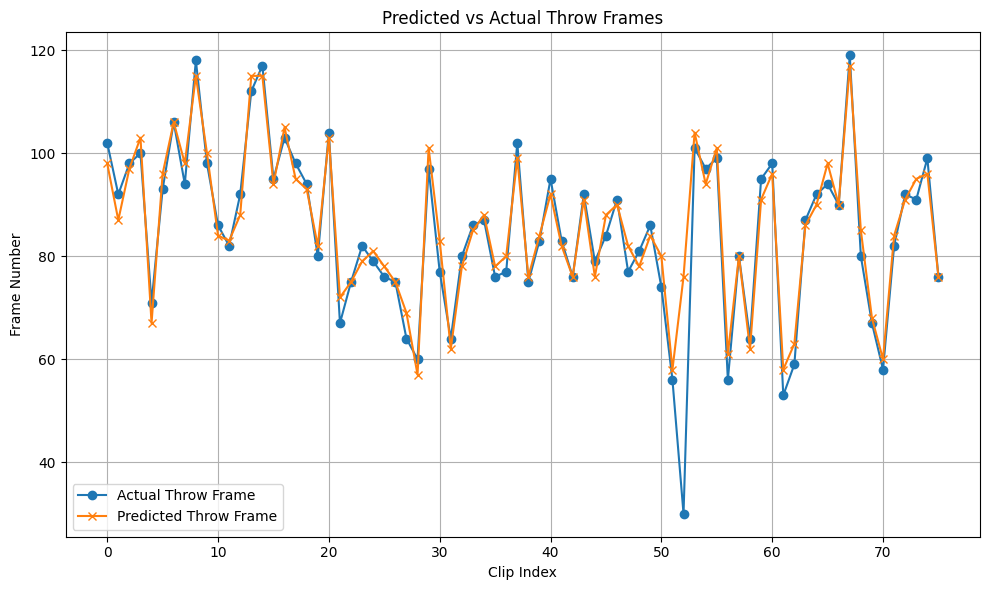

In [39]:
# ==== MAIN ====
if __name__ == "__main__":
    # Train the model
    clf = train_throw_frame_detector(CLIP_FOLDER, THROW_FRAMES, window=WINDOW)

    # Predict throw frames for all clips
    PRED_FRAMES = batch_predict_and_save(clf, CLIP_FOLDER, OUTPUT_FOLDER, window=WINDOW)

    # Evaluate and visualize results
    true_frames, predicted_frames = evaluate_predictions(PRED_FRAMES, THROW_FRAMES)
    plot_predictions(true_frames, predicted_frames)